In [1]:
# Parameters (Papermill will override these)
RAW_ZIP_PATH = 'data/raw/PRSA2017_Data_20130301-20170228.zip'
OUTPUT_CLEANED_PATH = 'data/processed/beijing_pm25_processed.csv'
LAG_HOURS = [1, 3, 24]

In [2]:
# Parameters
USE_UCIMLREPO = False
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"
OUTPUT_CLEANED_PATH = "data/processed/cleaned.parquet"
LAG_HOURS = [1, 3, 24]


In [3]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Determine Project Root to import src
current_dir = Path(os.getcwd())
if current_dir.name == 'runs':
    PROJECT_ROOT = current_dir.parent.parent
elif current_dir.name == 'notebooks':
    PROJECT_ROOT = current_dir.parent
else:
    PROJECT_ROOT = current_dir

sys.path.append(str(PROJECT_ROOT))

from src.classification_library import load_beijing_air_quality, clean_air_quality_df

print(f"Project Root: {PROJECT_ROOT}")

Project Root: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries


In [4]:
# Load Data from Raw ZIP
raw_zip_abs = PROJECT_ROOT / RAW_ZIP_PATH
if not raw_zip_abs.exists():
    # Fallback try relative
    raw_zip_abs = Path(RAW_ZIP_PATH).resolve()

print(f"Loading data from: {raw_zip_abs}")

try:
    df = load_beijing_air_quality(use_ucimlrepo=False, raw_zip_path=str(raw_zip_abs))
    df = clean_air_quality_df(df)
    print("Data loaded and cleaned successfully.")
except Exception as e:
    print(f"Error loading data: {e}")
    raise e

# Ensure datetime is datetime type
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])

# Filter for Aotizhongxin just for EDA visualization focus (optional but good for consistency)
# If we want to save ALL data, we shouldn't filter, but for the specific plots requested (PM2.5 Aotizhongxin)...
# Let's keep all data in df, but create subset for plotting.

# Save processed intermediate file if needed
out_path = PROJECT_ROOT / OUTPUT_CLEANED_PATH
out_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_path, index=False)
print(f"Saved processed data to: {out_path}")

Loading data from: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\raw\PRSA2017_Data_20130301-20170228.zip


Data loaded and cleaned successfully.


Saved processed data to: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\processed\cleaned.parquet


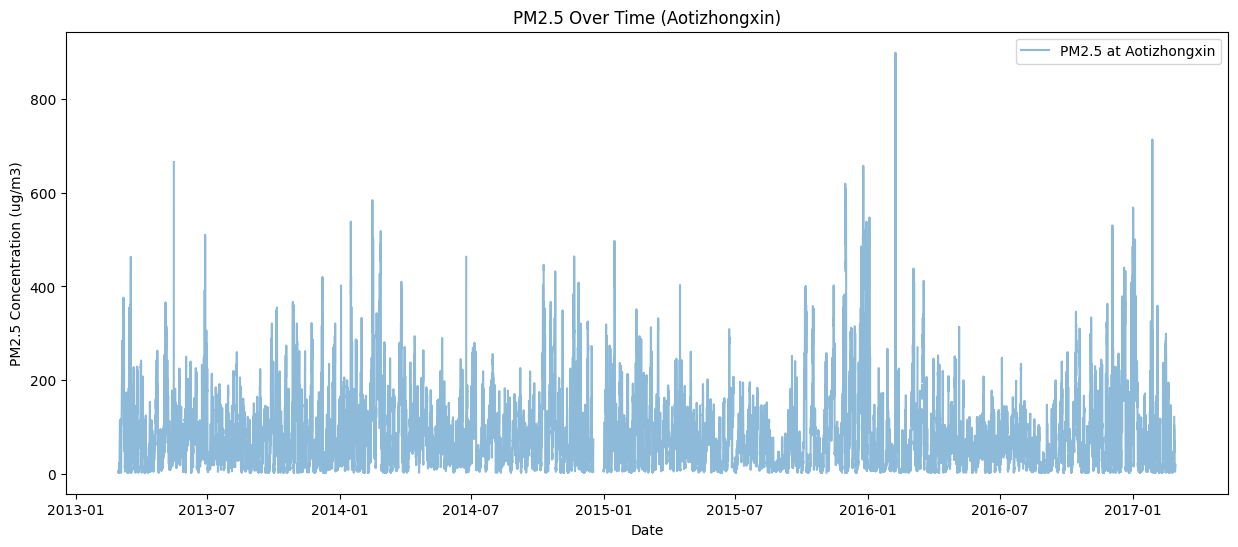

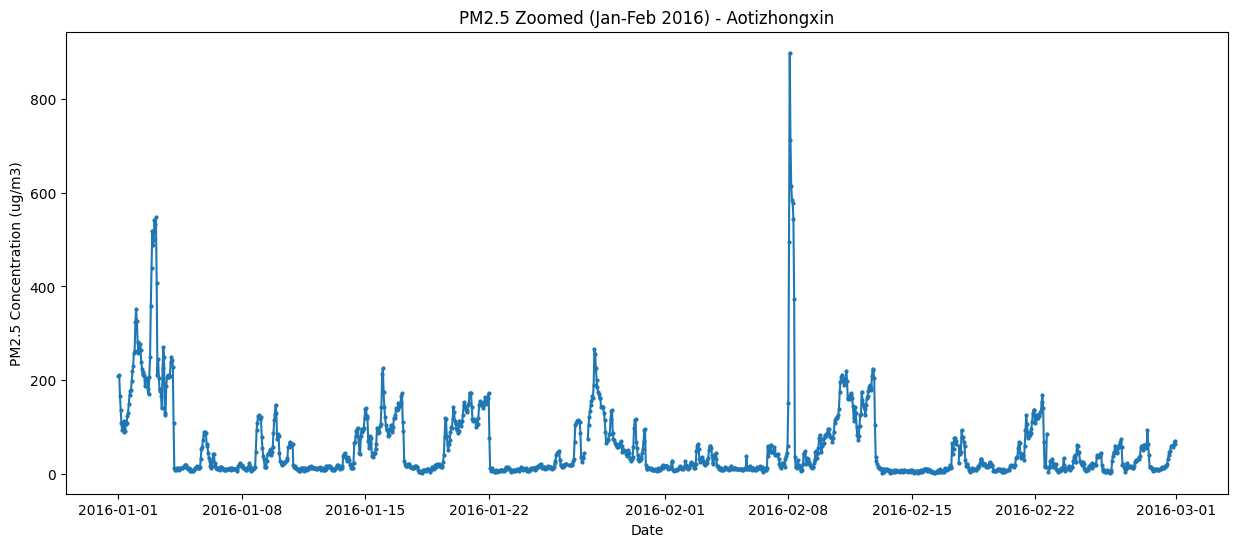

In [5]:
os.makedirs('images', exist_ok=True)

# 1. Visualizing PM2.5 (Aotizhongxin)
station_name = 'Aotizhongxin'
if 'station' in df.columns:
    subset = df[df['station'] == station_name].sort_values('datetime')
else:
    subset = df.sort_values('datetime')

plt.figure(figsize=(15, 6))
plt.plot(subset['datetime'], subset['PM2.5'], label=f'PM2.5 at {station_name}', alpha=0.5)
plt.title(f'PM2.5 Over Time ({station_name})')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration (ug/m3)')
plt.legend()
plt.savefig('images/eda_pm25_full.png')
plt.show()

# Zoom in 2 months (Example: Jan-Feb 2016)
subset_zoom = subset[(subset['datetime'] >= '2016-01-01') & (subset['datetime'] < '2016-03-01')]
plt.figure(figsize=(15, 6))
plt.plot(subset_zoom['datetime'], subset_zoom['PM2.5'], marker='o', markersize=2)
plt.title(f'PM2.5 Zoomed (Jan-Feb 2016) - {station_name}')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration (ug/m3)')
plt.savefig('images/eda_pm25_zoom.png')
plt.show()

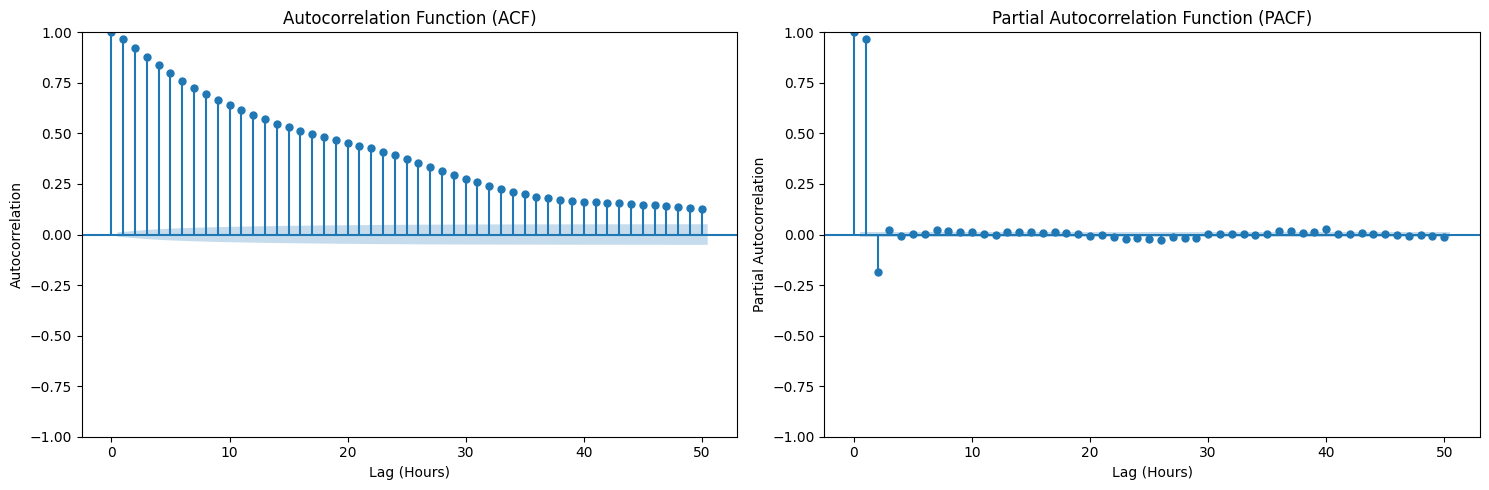

Autocorrelation at 24h: 0.394
Autocorrelation at 168h (1 week): 0.018


In [6]:
# 2. Autocorrelation Analysis
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(subset['PM2.5'].dropna(), lags=50, ax=ax[0])
ax[0].set_xlabel('Lag (Hours)')
ax[0].set_ylabel('Autocorrelation')
ax[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(subset['PM2.5'].dropna(), lags=50, ax=ax[1])
ax[1].set_xlabel('Lag (Hours)')
ax[1].set_ylabel('Partial Autocorrelation')
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.savefig('images/eda_acf_pacf.png')
plt.show()

lag_24 = subset['PM2.5'].autocorr(lag=24)
lag_168 = subset['PM2.5'].autocorr(lag=168)
print(f"Autocorrelation at 24h: {lag_24:.3f}")
print(f"Autocorrelation at 168h (1 week): {lag_168:.3f}")

In [7]:
# 3. Stationarity Tests
def check_stationarity(series):
    print('--- ADF Test ---')
    try:
        adf_result = adfuller(series.dropna())
        print(f'ADF Statistic: {adf_result[0]:.4f}')
        print(f'p-value: {adf_result[1]:.4f}')
    except Exception as e:
        print(f'ADF Error: {e}')

    print('\n--- KPSS Test ---')
    try:
        kpss_result = kpss(series.dropna(), regression='c', nlags="auto")
        print(f'KPSS Statistic: {kpss_result[0]:.4f}')
        print(f'p-value: {kpss_result[1]:.4f}')
    except Exception as e:
        print(f'KPSS Error: {e}')

print("Stationarity Test Results for PM2.5:")
check_stationarity(subset['PM2.5'])

Stationarity Test Results for PM2.5:
--- ADF Test ---


ADF Statistic: -19.5261
p-value: 0.0000

--- KPSS Test ---
KPSS Statistic: 0.2008
p-value: 0.1000


C:\Users\ThanhTung\AppData\Local\Temp\ipykernel_18656\92064048.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c', nlags="auto")
